# OpenStreetMap Data Case Study

## Map Area
Central Singapore, Singapore

<img src="https://dl.dropboxusercontent.com/s/wugrsslbv6ml312/central_singapore.png" width="414" height="407" />

- [MapZen](https://mapzen.com/data/metro-extracts/your-extracts/b64f3acb79eb)

The map that I’ve chosen is Central Singapore, which is a part of the country that I’m currently living. The map is retrieved by using custom extracts function provided by Mapzen.

## 1. Problems Encountered in the Map

After auditing a subsample of the original map data, I noticed two main problems with the data:
- Abbreviated street name  *('Orchard Rd')*
- Incorrect postal codes (Singapore’s postal code is 6-digit numbers but a large portion of the postal codes only consist 5-digit)

### Abbreviated Street Name

In Singapore map, the name abbreviations can appear in any position of the street address, not just at the end of the street name. To find the list of abbreviations, I first compared the street name with a list of possible keywords that could appear in typical address in Singapore map. Beside regular keywords such as *Street* and *Avenue*, the list also includes some local keywords such as *Jalan*, *Lorong* and *Taman* which are commonly used in Singapore’s street name. 


```python
# The list of possible street keywords in Singapore map
expected_street= ["Street", "Avenue", "Boulevard", "Central", "Circle", "Close", "Crescent", 
            "Court", "Drive", "Grove", "Heights", "Jalan", "Park", "Place", 
            "Square", "Loop", "Lane", "Link", "Lorong", 
            "Road",  "Taman", "Terrace",  "Trail", "View", "Walk", "Way" ]
            
def compare_street_name(street_types, street_name):
    '''
    This function checks if the street name contains any of the defined possible keywords.
    If no, the street name is stored in a dictionary with the last word
    of the street name as the key.    
    '''
    if not list(set(street_name.split()).intersection(set(expected_street))):
        street_types[street_name.split()[-1]].add(street_name)            
```

In the above function, if the street name doesn’t contain any possible keywords, the street name is stored in *street_types* dictionary with the last word of the street name as the key. After inspecting the *street_types* dictionary, I managed to find a few commonly used abbreviations in the street address. These abbreviations were corrected before the map was converted to JSON format. 

### Incorrect Postal Codes

In Singapore, all postal codes are consisted of six digits. After auditing the postal codes using the following function, I found that a few addresses have postal code with only five digits and all these addresses are contributed by the same user,  `JaLooNz`. After cross referencing these five digits postal codes with Google Map, I discovered that this particular user has the tendency of omitting the first digit of the postal code starts with 0. For instance, *'069544'* corresponding to Cecil Street in Singapore was stored as *'69544'* in the map data. 

```python
def compare_postcode(user_postcodes, postcode, user, street_name):
    '''
    This function checks whether the postal code is 6 digits.  
    If the postal code is not 6 digits, the postal code is stored in 
    a dictionary with the user name as the key.
    '''
    if len(postcode)!=6:
        user_postcodes[user].add(postcode)    
        
        # Print the streetname along with the postal code
        print(street_name + ": " + postcode)
```

To correct these incorrect postal codes, I simply appended '0' at the front of these postal codes contributed by user `JaLooNz`.

## 2. Data Overview

This section contains basic statistics about the dataset and the MongoDB queries used to gather them.

### File sizes
```
central_singapore.osm ....... 110 MB
central_singapore.json....... 158 MB
```

In [15]:
# Import the necessary libraries
import pandas as pd
from pymongo import MongoClient
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def get_db():
    '''
    The json file was first imported to MongoDB database 
    by using following command:
    mongoimport -d maps -c sg --file central_singapore.json
    '''
    client = MongoClient("mongodb://localhost:27017")
    db = client.maps
    return db

db = get_db()

### Number of Documents

In [5]:
db.sg.find().count()       

572149

### Number of Nodes

In [6]:
query = {"type": "node"} 
db.sg.find(query).count()

487381

### Number of Ways

In [7]:
query = {"type": "way"} 
db.sg.find(query).count()

84768

### Number of Unique Users

In [10]:
len(db.sg.distinct("created.user"))

1027

### Top 10 Contributing Users

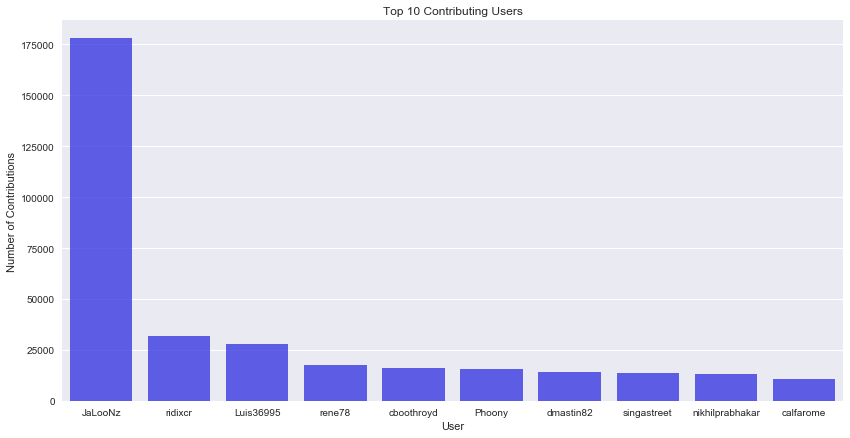

In [49]:
pipeline = [
        {"$group": {"_id": "$created.user",
                    "count": {"$sum": 1} } } ,
        {"$sort": {"count": -1}},
        {"$limit": 10}        
        ]
   
result = [doc for doc in db.sg.aggregate(pipeline)]
df = pd.DataFrame(result)

# Plot the top 10 contributing users
plt.figure(figsize=(14,7))
sns.set_style('darkgrid')
sns.barplot(x = "_id",y = "count",
            data = df, color = 'b', alpha = 0.7).set(xlabel = 'User',
                                                     ylabel = 'Number of Contributions',
                                                     title = "Top 10 Contributing Users");

In [59]:
print("The most contributing user, {} contributed about {:,.2f}% of this dataset." \
      .format(df.iloc[0]["_id"], \
              df.iloc[0]["count"]/db.sg.find().count()*100 ))

print("Top 10 contributing users provided approximately {:,.2f}% of this dataset."\
     .format(sum(df["count"])/db.sg.find().count()*100))

The most contributing user, JaLooNz contributed about 31.11% of this dataset.
Top 10 contributing users provided approximately 59.13% of this dataset.


It is interesting to notice that the most contributing user, `JaLooNz` is also the same user who omitting a lot of first digit of the postal code starts with 0.

## 3. Additional Data Exploration Using MongoDB Queries

### Top 10 Appearing Amenities

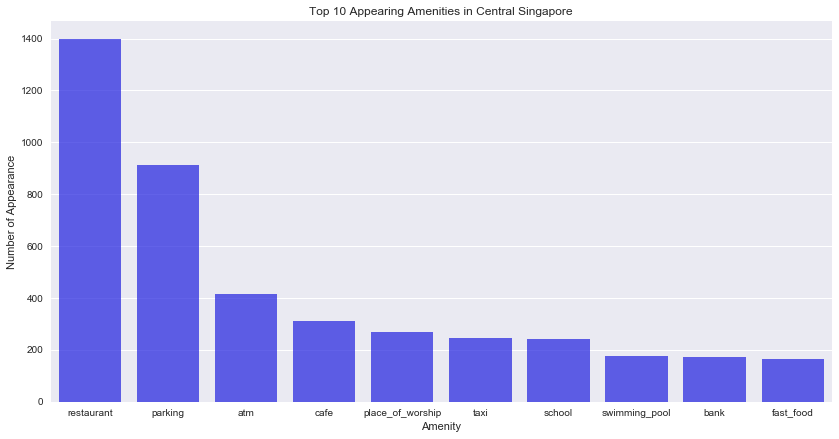

In [47]:
pipeline = [
        {"$match": {"amenity": {"$exists": 1} } },
        {"$group": {"_id": "$amenity",
                    "count": {"$sum": 1} } } ,
        {"$sort": {"count": -1}},
        {"$limit": 10}        
        ]
   
result = [doc for doc in db.sg.aggregate(pipeline)]
df = pd.DataFrame(result)

# Plot the top 10 appearing amenities
plt.figure(figsize=(14,7))
sns.set_style('darkgrid')
sns.barplot(x = "_id",y = "count",
            data = df, color = 'b', alpha = 0.7).set(xlabel = 'Amenity',
                                                     ylabel = 'Number of Appearance',                                                           
                                                     title = "Top 10 Appearing Amenities in Central Singapore");

### Most Popular Cuisines

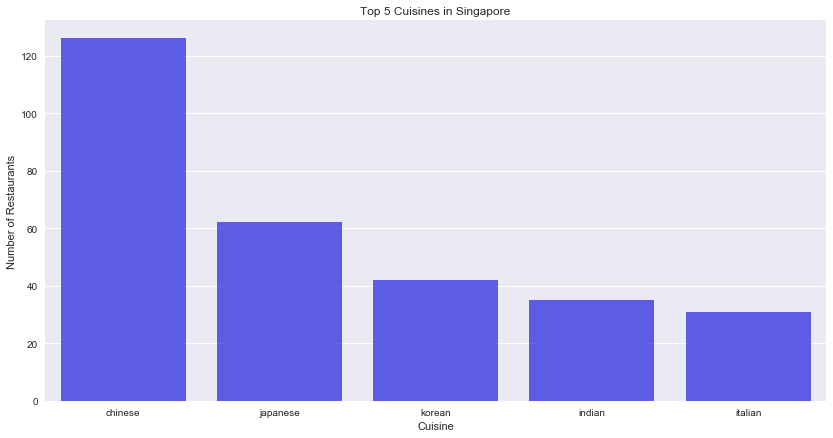

In [46]:
pipeline = [
        {"$match": {"amenity": {"$exists": 1},
                    "cuisine": {"$exists": 1},
                    "amenity": "restaurant"}},
        {"$group": {"_id": "$cuisine",
                    "count": {"$sum": 1} } } ,
        {"$sort": {"count": -1}},
        {"$limit": 5}        
        ]
result = [doc for doc in db.sg.aggregate(pipeline)]
df = pd.DataFrame(result) 

# Plot the Top 5 Most Popular Cuisines
plt.figure(figsize=(14,7))
sns.set_style('darkgrid')
sns.barplot(x = "_id",y = "count",
            data = df, color = 'b', alpha = 0.7).set(xlabel = 'Cuisine',
                                                     ylabel = 'Number of Restaurants', 
                                                     title = "Top 5 Cuisines in Singapore");

### Bank With Most Number of Branches

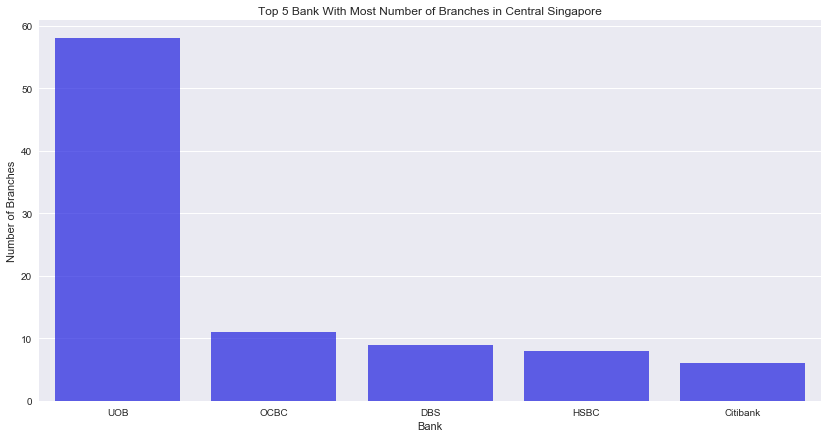

In [45]:
pipeline = [
        {"$match": {"amenity": {"$exists": 1},
                    "name": {"$exists": 1},
                    "amenity": "bank"}},
        {"$group": {"_id": "$name",
                    "count": {"$sum": 1} } } ,
        {"$sort": {"count": -1}},
        {"$limit": 5}        
        ]
result = [doc for doc in db.sg.aggregate(pipeline)]
df = pd.DataFrame(result) 

# Plot the Top 5 Bank With Most Number of Branches
plt.figure(figsize=(14,7))
sns.set_style('darkgrid')
sns.barplot(x = "_id",y = "count",
            data = df, color = 'b', alpha = 0.7).set(xlabel = 'Bank',
                                                     ylabel = 'Number of Branches',                         
                                                     title = "Top 5 Bank With Most Number of Branches in Central Singapore");

## 4. Additional Improvements Idea

### Postal Codes Which Are Not 6-Digit Numbers

In [61]:
query ={"address.postcode": {"$exists": 1},
        "$where": "this.address.postcode.length!=6"}
projection = {"_id": 0, "address.postcode": 1, "address.street": 1}
postcodes = db.sg.find(query, projection)

# Print the problematic postal codes along with user name    
for code in postcodes:
    pprint.pprint(code)

{'address': {'postcode': '135', 'street': 'Jalan Pelatina'}}
{'address': {'postcode': 'Singapore 408564', 'street': 'Blk 10 Ubi Crescent'}}
{'address': {'postcode': '2424', 'street': 'Orchard Road'}}
{'address': {'postcode': 'S 278989', 'street': 'Holland Avenue'}}
{'address': {'postcode': '88752'}}
{'address': {'postcode': '40893', 'street': 'North Bridge Road'}}
{'address': {'postcode': '4374400', 'street': 'Rhu Cross'}}
{'address': {'postcode': '437 437', 'street': 'Rhu Cross'}}
{'address': {'postcode': '80739', 'street': 'Saraca Road'}}
{'address': {'postcode': '80464', 'street': 'Mimosa Drive'}}
{'address': {'postcode': '80463', 'street': 'Mimosa Drive'}}
{'address': {'postcode': '80800', 'street': 'Mimosa Road'}}
{'address': {'postcode': '74', 'street': '310074'}}
{'address': {'postcode': '562', 'street': 'Hougang street 51'}}


While majority of the incorrect postal codes have been updated before converting JSON format, there are still many incorrect or inconsistent format postal codes in the dataset. These are individual isolated cases and difficult to be corrected programmatically. It could be done manually by cross referencing to third party dataset like Google or Bing.

## 5. Conclusion

Although this Central Singapore map data is relatively clean when compared to other metropolitan areas, I believe there are a few areas of improvement. First, about 31.11% of this dataset was contributed by a single user. Since I already discovered many incorrect postal codes in the address tags contributed by this user, I believe there are potential errors in other tags which I have yet to look at in detail. This would require significant amount of time and effort. Secondly, while doing data exploration exercises using MongoDB queries, I discovered that many amenities doesn’t have a name attribute. These names could be added to the map to make the dataset more complete. 